In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [3]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from tqdm.notebook import tqdm

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [5]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [6]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [7]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [8]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Investigating Whitening Methods

In [ ]:
csp_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [ ]:
signal = []
label = []
for sig, lbl in tqdm(csp_dataloader):
    signal.append(sig)
    label.append(lbl["label"])
signal = torch.vstack(signal)
label = torch.stack(label)

In [ ]:
signal.size(), label.size()

In [ ]:
import matplotlib.pyplot as plt
import scipy.linalg as la

In [ ]:
def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov

In [ ]:
x = signal.squeeze()
sig = x.permute(0, 2, 1)
x = torch.mean(sig, axis=1)
x_mean = torch.mean(x, axis=0)
sig.size(), x_mean.size()

In [ ]:
x = sig - x_mean
x_zero_centered = x.permute(0, 2, 1)
x_zero_centered.size()

In [ ]:
x = x_zero_centered
x_cov = calc_cov(x)
x_cov.shape

In [ ]:
plt.imshow(x_cov, cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
lda, V = torch.linalg.eig(x_cov)
lda, V = lda.real, V.real
whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
# print(torch.allclose(whitening_mat, torch.sqrt(torch.inverse(x_cov))))
# whitening_mat = torch.inverse(torch.sqrt(x_cov))

whitening_mat.size()

In [ ]:
plt.imshow(whitening_mat, cmap="hot", interpolation="nearest")
plt.show()

In [ ]:
whitened_signal = whitening_mat @ x_zero_centered
whitened_signal.size()

In [ ]:
x = whitened_signal
whitened_signal_cov = calc_cov(x)
whitened_signal_cov.shape

In [ ]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

## Pytorch Dataset Transform Model

In [9]:
import matplotlib.pyplot as plt
import scipy.linalg as la


def calc_cov(EEG_data):
    """
    INPUT:
    EEG_data : EEG_data in shape T x N x S

    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    """
    cov = []
    for i in range(EEG_data.size()[0]):
        cov.append(
            EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
        )

    cov = torch.mean(torch.stack(cov), 0)

    return cov


class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [10]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[5],
)

In [11]:
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

In [13]:
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds_w = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[5],
)

In [14]:
ds_w[0][0].size()

torch.Size([1, 22, 1, 1, 1001])

In [15]:
# train_dataset, _ = ds_w.get_train_test_subsets()

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=collate_fn,
#     num_workers=1,
# )

batch_size = 32
train_dataset, val_dataset = ds_w.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

In [16]:
signal = []
for sig, lbl in tqdm(train_dataloader):
    signal.append(sig)
signal = torch.vstack(signal)
signal.size()

  0%|          | 0/9 [00:00<?, ?it/s]

torch.Size([288, 22, 1, 1, 1001])

In [17]:
whitened_signal_cov = calc_cov(signal.squeeze())
whitened_signal_cov.shape

torch.Size([22, 22])

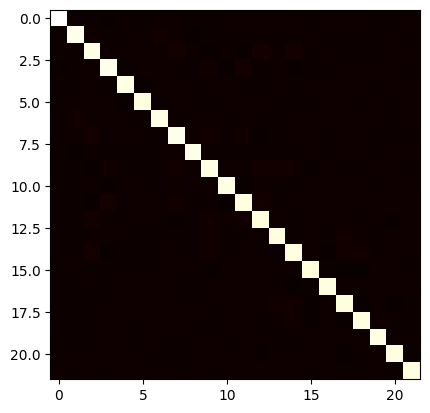

In [18]:
plt.imshow(whitened_signal_cov, cmap="hot", interpolation="nearest")
plt.show()

# Model

In [19]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

import torch.optim as optim

import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [20]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [22]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        self.fc1 = nn.Linear(
            self.num_bands * self.num_windows * self.num_labels * self.num_features, 500
        )
        self.fc = nn.Linear(500, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        x = torch.tanh(self.fc1(features))

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22, num_features=22, num_bands=1, num_windows=1, num_labels=4
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [23]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

In [24]:
net = net.cuda()

In [ ]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "lr": [],
    "train_kappa": [],
    "test_kappa": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])


Epoch  0


9it [00:01,  5.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4187326696183946


Train -  [0.2534722222222222, 0.00462962962962965, 0.5771604938271605, 0.2534722222222222, tensor(1.3973)]
Validation -  [0.25, 0.0, 0.5271026234567902, 0.25, tensor(1.3976)]

Epoch  1


9it [00:00, 11.03it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.4114388624827068


Train -  [0.25, 0.0, 0.6377716692386831, 0.25, tensor(1.4079)]
Validation -  [0.25, 0.0, 0.5634162808641976, 0.25, tensor(1.4091)]

Epoch  2


9it [00:00, 10.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.415888057814704


Train -  [0.25, 0.0, 0.6588220164609053, 0.25, tensor(1.3958)]
Validation -  [0.25, 0.0, 0.5827707047325104, 0.25, tensor(1.3973)]

Epoch  3


9it [00:00,  9.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3959003289540608


Train -  [0.25, 0.0, 0.6524080504115226, 0.25, tensor(1.3899)]
Validation -  [0.25, 0.0, 0.5831725823045268, 0.25, tensor(1.3911)]

Epoch  4


9it [00:00, 11.41it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3911937077840169


Train -  [0.25, 0.0, 0.6688207304526748, 0.25, tensor(1.3882)]
Validation -  [0.25, 0.0, 0.5889756944444444, 0.25, tensor(1.3896)]

Epoch  5


9it [00:01,  8.59it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.397386418448554


Train -  [0.25, 0.0, 0.7020318930041153, 0.25, tensor(1.3892)]
Validation -  [0.25, 0.0, 0.6031057098765432, 0.25, tensor(1.3906)]

Epoch  6


9it [00:00, 10.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3934615585539076


Train -  [0.25, 0.0, 0.7223025977366254, 0.25, tensor(1.3863)]
Validation -  [0.25, 0.0, 0.6129275977366255, 0.25, tensor(1.3884)]

Epoch  7


9it [00:00, 10.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3911610576841567


Train -  [0.34375, 0.125, 0.7333301183127572, 0.34375, tensor(1.3812)]
Validation -  [0.2638888888888889, 0.01851851851851849, 0.6260609567901234, 0.2638888888888889, tensor(1.3845)]

Epoch  8


9it [00:00, 10.91it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3840158780415852


Train -  [0.2604166666666667, 0.01388888888888884, 0.7434895833333333, 0.2604166666666667, tensor(1.3812)]
Validation -  [0.25, 0.0, 0.6294528034979424, 0.25, tensor(1.3845)]

Epoch  9


9it [00:00,  9.57it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3846471044752333


Train -  [0.3506944444444444, 0.1342592592592593, 0.7508198302469136, 0.3506944444444444, tensor(1.3777)]
Validation -  [0.3055555555555556, 0.07407407407407407, 0.6363490226337448, 0.3055555555555556, tensor(1.3827)]

Epoch  10


9it [00:00, 12.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.390132360988193


Train -  [0.25, 0.0, 0.7483281893004115, 0.25, tensor(1.3794)]
Validation -  [0.25, 0.0, 0.6445634002057613, 0.25, tensor(1.3851)]

Epoch  11


9it [00:00,  9.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3835723797480266


Train -  [0.3020833333333333, 0.06944444444444442, 0.7414158950617283, 0.3020833333333333, tensor(1.3779)]
Validation -  [0.3020833333333333, 0.06944444444444442, 0.647778420781893, 0.3020833333333333, tensor(1.3832)]

Epoch  12


9it [00:00, 12.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3853783739937677


Train -  [0.3159722222222222, 0.08796296296296291, 0.7489390432098766, 0.3159722222222222, tensor(1.3695)]
Validation -  [0.3125, 0.08333333333333337, 0.652954603909465, 0.3125, tensor(1.3772)]

Epoch  13


9it [00:00, 11.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.380211936102973


Train -  [0.3993055555555556, 0.19907407407407407, 0.7550154320987654, 0.3993055555555556, tensor(1.3660)]
Validation -  [0.2847222222222222, 0.04629629629629628, 0.6564589763374487, 0.2847222222222222, tensor(1.3753)]

Epoch  14


9it [00:00, 10.24it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3881408638424344


Train -  [0.2638888888888889, 0.01851851851851849, 0.7460776748971194, 0.2638888888888889, tensor(1.3783)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.6579700360082305, 0.2569444444444444, tensor(1.3855)]

Epoch  15


9it [00:00, 11.15it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3688641389211018


Train -  [0.3472222222222222, 0.12962962962962965, 0.7340856481481483, 0.3472222222222222, tensor(1.3634)]
Validation -  [0.3159722222222222, 0.08796296296296291, 0.663210519547325, 0.3159722222222222, tensor(1.3735)]

Epoch  16


9it [00:00, 11.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.365284072028266


Train -  [0.3923611111111111, 0.18981481481481477, 0.7552083333333333, 0.3923611111111111, tensor(1.3540)]
Validation -  [0.3263888888888889, 0.10185185185185186, 0.6708622685185185, 0.3263888888888889, tensor(1.3660)]

Epoch  17


9it [00:00,  9.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3639344109429254


Train -  [0.3159722222222222, 0.08796296296296291, 0.7316100823045267, 0.3159722222222222, tensor(1.3504)]
Validation -  [0.3055555555555556, 0.07407407407407407, 0.6666988168724279, 0.3055555555555556, tensor(1.3621)]

Epoch  18


9it [00:00,  9.36it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3533952236175537


Train -  [0.2847222222222222, 0.04629629629629628, 0.7048128858024691, 0.2847222222222222, tensor(1.3562)]
Validation -  [0.2847222222222222, 0.04629629629629628, 0.6569412294238683, 0.2847222222222222, tensor(1.3654)]

Epoch  19


9it [00:00, 12.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3503149615393744


Train -  [0.3923611111111111, 0.18981481481481477, 0.7528774434156378, 0.3923611111111111, tensor(1.3373)]
Validation -  [0.3229166666666667, 0.09722222222222221, 0.6757651748971194, 0.3229166666666667, tensor(1.3541)]

Epoch  20


9it [00:00, 11.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3556100924809773


Train -  [0.3993055555555556, 0.19907407407407407, 0.7437307098765432, 0.3993055555555556, tensor(1.3313)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6758937757201646, 0.3333333333333333, tensor(1.3486)]

Epoch  21


9it [00:00, 10.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3473264508777194


Train -  [0.3229166666666667, 0.09722222222222221, 0.6841242283950617, 0.3229166666666667, tensor(1.3587)]
Validation -  [0.3506944444444444, 0.1342592592592593, 0.6456243569958847, 0.3506944444444444, tensor(1.3659)]

Epoch  22


9it [00:01,  8.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3549476199679904


Train -  [0.3263888888888889, 0.10185185185185186, 0.7318431712962963, 0.3263888888888889, tensor(1.3534)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.6579378858024691, 0.2986111111111111, tensor(1.3751)]

Epoch  23


9it [00:00,  9.20it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3901360564761691


Train -  [0.3715277777777778, 0.1620370370370371, 0.7300507973251029, 0.3715277777777778, tensor(1.3525)]
Validation -  [0.3263888888888889, 0.10185185185185186, 0.6811985596707819, 0.3263888888888889, tensor(1.3780)]

Epoch  24


9it [00:01,  8.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3946743143929377


Train -  [0.3854166666666667, 0.18055555555555558, 0.6974183384773662, 0.38541666666666663, tensor(1.3545)]
Validation -  [0.3541666666666667, 0.13888888888888884, 0.6623906893004115, 0.3541666666666667, tensor(1.3695)]

Epoch  25


9it [00:00, 12.14it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3573704030778673


Train -  [0.4201388888888889, 0.22685185185185186, 0.7180909207818931, 0.4201388888888889, tensor(1.3366)]
Validation -  [0.3298611111111111, 0.10648148148148151, 0.6820183899176955, 0.3298611111111111, tensor(1.3593)]

Epoch  26


9it [00:01,  8.89it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3357029755910237


Train -  [0.3576388888888889, 0.1435185185185185, 0.7093621399176955, 0.3576388888888889, tensor(1.3385)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.6400945216049383, 0.2986111111111111, tensor(1.3657)]

Epoch  27


9it [00:01,  8.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.370244688457913


Train -  [0.3229166666666667, 0.09722222222222221, 0.7107606738683128, 0.3229166666666667, tensor(1.3802)]
Validation -  [0.2951388888888889, 0.06018518518518523, 0.6636927726337448, 0.2951388888888889, tensor(1.4033)]

Epoch  28


9it [00:00,  9.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.358382436964247


Train -  [0.4027777777777778, 0.20370370370370372, 0.7323816872427983, 0.4027777777777778, tensor(1.3227)]
Validation -  [0.3125, 0.08333333333333337, 0.6713445216049382, 0.3125, tensor(1.3516)]

Epoch  29


9it [00:01,  6.99it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3528974056243896


Train -  [0.2638888888888889, 0.01851851851851849, 0.6733699845679013, 0.2638888888888889, tensor(1.3722)]
Validation -  [0.2708333333333333, 0.02777777777777779, 0.6341949588477367, 0.2708333333333333, tensor(1.3716)]

Epoch  30


9it [00:01,  7.86it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3507737053765192


Train -  [0.34375, 0.125, 0.7053915895061729, 0.34375, tensor(1.3585)]
Validation -  [0.2673611111111111, 0.02314814814814814, 0.6304012345679012, 0.2673611111111111, tensor(1.3819)]

Epoch  31


9it [00:01,  6.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.342868937386407


Train -  [0.4166666666666667, 0.2222222222222222, 0.729713220164609, 0.4166666666666667, tensor(1.3148)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6816325874485597, 0.3333333333333333, tensor(1.3445)]

Epoch  32


9it [00:01,  6.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3371904691060383


Train -  [0.3506944444444444, 0.1342592592592593, 0.6976916152263374, 0.3506944444444444, tensor(1.3251)]
Validation -  [0.3611111111111111, 0.14814814814814814, 0.6572788065843622, 0.3611111111111111, tensor(1.3370)]

Epoch  33


9it [00:01,  5.67it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3143793212042914


Train -  [0.4166666666666667, 0.2222222222222222, 0.7331372170781892, 0.4166666666666667, tensor(1.3056)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.6834329989711934, 0.3888888888888889, tensor(1.3327)]

Epoch  34


9it [00:01,  6.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.31441417005327


Train -  [0.3715277777777778, 0.1620370370370371, 0.7348572530864198, 0.3715277777777778, tensor(1.3123)]
Validation -  [0.3263888888888889, 0.10185185185185186, 0.660011574074074, 0.3263888888888889, tensor(1.3491)]

Epoch  35


9it [00:01,  6.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3131076362397935


Train -  [0.4027777777777778, 0.20370370370370372, 0.7290702160493827, 0.4027777777777778, tensor(1.3047)]
Validation -  [0.3506944444444444, 0.1342592592592593, 0.6771637088477366, 0.3506944444444444, tensor(1.3298)]

Epoch  36


9it [00:01,  6.04it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2963965468936496


Train -  [0.4270833333333333, 0.23611111111111116, 0.7486979166666667, 0.4270833333333333, tensor(1.2954)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6793820730452675, 0.3333333333333333, tensor(1.3315)]

Epoch  37


9it [00:01,  6.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.310615552796258


Train -  [0.4236111111111111, 0.2314814814814815, 0.7500482253086419, 0.4236111111111111, tensor(1.2933)]
Validation -  [0.3402777777777778, 0.12037037037037035, 0.683915252057613, 0.3402777777777778, tensor(1.3337)]

Epoch  38


9it [00:01,  6.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3222322861353557


Train -  [0.3472222222222222, 0.12962962962962965, 0.7458686985596708, 0.3472222222222222, tensor(1.3300)]
Validation -  [0.28125, 0.04166666666666663, 0.6498199588477367, 0.28125, tensor(1.3678)]

Epoch  39


9it [00:01,  5.60it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3312850925657485


Train -  [0.4097222222222222, 0.2129629629629629, 0.7280092592592592, 0.4097222222222222, tensor(1.3153)]
Validation -  [0.3645833333333333, 0.1527777777777778, 0.6707175925925926, 0.36458333333333326, tensor(1.3409)]

Epoch  40


9it [00:01,  6.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3283648623360529


Train -  [0.3576388888888889, 0.1435185185185185, 0.7043306327160495, 0.3576388888888889, tensor(1.3369)]
Validation -  [0.34375, 0.125, 0.6461548353909465, 0.34375, tensor(1.3481)]

Epoch  41


9it [00:01,  6.76it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3288898600472345


Train -  [0.4548611111111111, 0.27314814814814814, 0.7455954218106997, 0.4548611111111111, tensor(1.2974)]
Validation -  [0.3506944444444444, 0.1342592592592593, 0.6772280092592593, 0.3506944444444444, tensor(1.3334)]

Epoch  42


9it [00:01,  6.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3257573710547552


Train -  [0.4027777777777778, 0.20370370370370372, 0.7731481481481483, 0.4027777777777778, tensor(1.2880)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6795267489711934, 0.3333333333333333, tensor(1.3362)]

Epoch  43


9it [00:01,  5.97it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.306514647271898


Train -  [0.3680555555555556, 0.15740740740740744, 0.7545974794238685, 0.36805555555555564, tensor(1.3208)]
Validation -  [0.3229166666666667, 0.09722222222222221, 0.6554140946502058, 0.3229166666666667, tensor(1.3734)]

Epoch  44


9it [00:01,  5.61it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3018435107337103


Train -  [0.3784722222222222, 0.17129629629629628, 0.7198591820987654, 0.3784722222222222, tensor(1.3214)]
Validation -  [0.3576388888888889, 0.1435185185185185, 0.6657986111111112, 0.3576388888888889, tensor(1.3384)]

Epoch  45


9it [00:01,  6.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3138817018932767


Train -  [0.4513888888888889, 0.2685185185185185, 0.7517521862139916, 0.4513888888888889, tensor(1.2967)]
Validation -  [0.3958333333333333, 0.19444444444444442, 0.6827417695473251, 0.3958333333333333, tensor(1.3367)]

Epoch  46


9it [00:01,  6.82it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3106850915484958


Train -  [0.4340277777777778, 0.24537037037037035, 0.7582143775720164, 0.4340277777777778, tensor(1.2966)]
Validation -  [0.3472222222222222, 0.12962962962962965, 0.6870177469135803, 0.3472222222222222, tensor(1.3510)]

Epoch  47


9it [00:01,  6.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3150453832414415


Train -  [0.3715277777777778, 0.1620370370370371, 0.7267232510288065, 0.3715277777777778, tensor(1.3387)]
Validation -  [0.3263888888888889, 0.10185185185185186, 0.6317676183127572, 0.3263888888888889, tensor(1.4029)]

Epoch  48


9it [00:01,  7.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3456737200419109


Train -  [0.3576388888888889, 0.1435185185185185, 0.7156475051440329, 0.3576388888888889, tensor(1.3519)]
Validation -  [0.3159722222222222, 0.08796296296296291, 0.6231513631687243, 0.3159722222222222, tensor(1.4106)]

Epoch  49


9it [00:01,  8.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.3363872501585219


Train -  [0.3333333333333333, 0.11111111111111116, 0.7040734310699589, 0.3333333333333333, tensor(1.3658)]
Validation -  [0.2986111111111111, 0.06481481481481477, 0.6164801954732511, 0.2986111111111111, tensor(1.4174)]

Epoch  50


9it [00:01,  8.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.305609557363722


Train -  [0.4236111111111111, 0.2314814814814815, 0.7644836676954732, 0.4236111111111111, tensor(1.2748)]
Validation -  [0.4375, 0.25, 0.689380787037037, 0.4375, tensor(1.3143)]

Epoch  51


9it [00:01,  8.65it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2881286806530423


Train -  [0.4340277777777778, 0.24537037037037035, 0.769016846707819, 0.4340277777777778, tensor(1.2723)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6644322273662551, 0.3333333333333333, tensor(1.3415)]

Epoch  52


9it [00:00,  9.64it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2729809549119737


Train -  [0.4826388888888889, 0.31018518518518523, 0.7751414609053497, 0.4826388888888889, tensor(1.2630)]
Validation -  [0.3645833333333333, 0.1527777777777778, 0.6845582561728395, 0.36458333333333326, tensor(1.3233)]

Epoch  53


9it [00:01,  7.19it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2806327475441828


Train -  [0.4340277777777778, 0.24537037037037035, 0.7490033436213992, 0.4340277777777778, tensor(1.2811)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.6801536779835391, 0.4166666666666667, tensor(1.3115)]

Epoch  54


9it [00:00, 10.80it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2792373100916545


Train -  [0.4722222222222222, 0.2962962962962963, 0.7676343878600824, 0.4722222222222222, tensor(1.2662)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.6859728652263374, 0.4236111111111111, tensor(1.3097)]

Epoch  55


9it [00:00,  9.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.275752756330702


Train -  [0.4756944444444444, 0.30092592592592593, 0.7827932098765432, 0.4756944444444444, tensor(1.2604)]
Validation -  [0.3229166666666667, 0.09722222222222221, 0.6587737911522634, 0.3229166666666667, tensor(1.3345)]

Epoch  56


9it [00:00,  9.01it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2627297242482503


Train -  [0.3923611111111111, 0.18981481481481477, 0.7610114454732511, 0.3923611111111111, tensor(1.2954)]
Validation -  [0.2881944444444444, 0.05092592592592593, 0.6386316872427983, 0.2881944444444444, tensor(1.3671)]

Epoch  57


9it [00:00, 11.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2828861872355144


Train -  [0.4895833333333333, 0.3194444444444444, 0.7759291409465021, 0.4895833333333333, tensor(1.2704)]
Validation -  [0.3715277777777778, 0.1620370370370371, 0.6832561728395062, 0.3715277777777778, tensor(1.3238)]

Epoch  58


9it [00:00,  9.50it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2667433420817058


Train -  [0.5069444444444444, 0.34259259259259256, 0.7980163323045268, 0.5069444444444444, tensor(1.2396)]
Validation -  [0.3715277777777778, 0.1620370370370371, 0.6841885288065843, 0.3715277777777778, tensor(1.3131)]

Epoch  59


9it [00:01,  8.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2611886660257976


Train -  [0.4548611111111111, 0.27314814814814814, 0.7979439943415638, 0.4548611111111111, tensor(1.2484)]
Validation -  [0.34375, 0.125, 0.6782246656378601, 0.34375, tensor(1.3295)]

Epoch  60


9it [00:01,  7.21it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520223193698459


Train -  [0.5069444444444444, 0.34259259259259256, 0.8063914609053497, 0.5069444444444444, tensor(1.2486)]
Validation -  [0.375, 0.16666666666666663, 0.665798611111111, 0.375, tensor(1.3274)]

Epoch  61


9it [00:01,  8.38it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.252999742825826


Train -  [0.5, 0.33333333333333337, 0.7720871913580247, 0.5, tensor(1.2620)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.6878375771604938, 0.4444444444444444, tensor(1.3006)]

Epoch  62


9it [00:00,  9.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.27828930483924


Train -  [0.4965277777777778, 0.3287037037037037, 0.7886766975308642, 0.4965277777777778, tensor(1.2446)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.6930298353909465, 0.4513888888888889, tensor(1.2969)]

Epoch  63


9it [00:00, 10.35it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2813049687279596


Train -  [0.4548611111111111, 0.27314814814814814, 0.789625128600823, 0.4548611111111111, tensor(1.2612)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6928047839506173, 0.4201388888888889, tensor(1.3126)]

Epoch  64


9it [00:01,  8.52it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2734944423039753


Train -  [0.4861111111111111, 0.31481481481481477, 0.7911361882716049, 0.4861111111111111, tensor(1.2544)]
Validation -  [0.375, 0.16666666666666663, 0.6907793209876543, 0.375, tensor(1.3169)]

Epoch  65


9it [00:00,  9.42it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2518739700317383


Train -  [0.4826388888888889, 0.31018518518518523, 0.8002829218106996, 0.4826388888888889, tensor(1.2487)]
Validation -  [0.3194444444444444, 0.09259259259259256, 0.6531314300411524, 0.3194444444444444, tensor(1.3489)]

Epoch  66


9it [00:00,  9.55it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2479459047317505


Train -  [0.5416666666666666, 0.38888888888888884, 0.8138985339506173, 0.5416666666666666, tensor(1.2195)]
Validation -  [0.3784722222222222, 0.17129629629629628, 0.6861657664609053, 0.3784722222222222, tensor(1.3057)]

Epoch  67


9it [00:00, 10.28it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2300386428833008


Train -  [0.4548611111111111, 0.27314814814814814, 0.8194765946502058, 0.4548611111111111, tensor(1.2409)]
Validation -  [0.3715277777777778, 0.1620370370370371, 0.6901041666666667, 0.3715277777777778, tensor(1.3117)]

Epoch  68


9it [00:00,  9.58it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2537769344117906


Train -  [0.4861111111111111, 0.31481481481481477, 0.8190586419753086, 0.4861111111111111, tensor(1.2276)]
Validation -  [0.3472222222222222, 0.12962962962962965, 0.6656378600823045, 0.3472222222222222, tensor(1.3370)]

Epoch  69


9it [00:00, 10.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2391296492682562


Train -  [0.4618055555555556, 0.28240740740740744, 0.8115354938271606, 0.4618055555555556, tensor(1.2309)]
Validation -  [0.4479166666666667, 0.26388888888888884, 0.6927887088477366, 0.4479166666666667, tensor(1.2964)]

Epoch  70


9it [00:00, 13.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2203461991416082


Train -  [0.5416666666666666, 0.38888888888888884, 0.8262763631687243, 0.5416666666666666, tensor(1.2154)]
Validation -  [0.3506944444444444, 0.1342592592592593, 0.6685956790123456, 0.3506944444444444, tensor(1.3231)]

Epoch  71


9it [00:00, 11.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2320895062552557


Train -  [0.5381944444444444, 0.3842592592592593, 0.8239454732510288, 0.5381944444444444, tensor(1.2184)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.6834972993827161, 0.3888888888888889, tensor(1.3163)]

Epoch  72


9it [00:00, 11.40it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2471062474780612


Train -  [0.4131944444444444, 0.21759259259259256, 0.782616383744856, 0.4131944444444444, tensor(1.2832)]
Validation -  [0.3715277777777778, 0.1620370370370371, 0.6887538580246914, 0.3715277777777778, tensor(1.3175)]

Epoch  73


9it [00:00, 10.11it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.308809717496236


Train -  [0.4097222222222222, 0.2129629629629629, 0.7880979938271605, 0.4097222222222222, tensor(1.3110)]
Validation -  [0.2916666666666667, 0.05555555555555558, 0.6506076388888888, 0.2916666666666667, tensor(1.3878)]

Epoch  74


9it [00:01,  8.18it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2235414584477742


Train -  [0.4444444444444444, 0.2592592592592593, 0.797389403292181, 0.4444444444444444, tensor(1.2485)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6950392232510288, 0.4201388888888889, tensor(1.2917)]

Epoch  75


9it [00:01,  8.47it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.238379054599338


Train -  [0.5555555555555556, 0.40740740740740744, 0.8271122685185186, 0.5555555555555556, tensor(1.2038)]
Validation -  [0.40625, 0.20833333333333337, 0.6920653292181069, 0.40625, tensor(1.2963)]

Epoch  76


9it [00:01,  6.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2468225028779771


Train -  [0.4270833333333333, 0.23611111111111116, 0.7811696244855968, 0.4270833333333333, tensor(1.2746)]
Validation -  [0.3125, 0.08333333333333337, 0.6340422453703703, 0.3125, tensor(1.3842)]

Epoch  77


9it [00:01,  7.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2753252188364665


Train -  [0.4479166666666667, 0.26388888888888884, 0.7965213477366255, 0.4479166666666667, tensor(1.2694)]
Validation -  [0.3333333333333333, 0.11111111111111116, 0.6431889789094651, 0.3333333333333333, tensor(1.3779)]

Epoch  78


9it [00:01,  7.54it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2264425622092352


Train -  [0.4756944444444444, 0.30092592592592593, 0.8117605452674896, 0.4756944444444444, tensor(1.2423)]
Validation -  [0.3402777777777778, 0.12037037037037035, 0.6544335133744856, 0.3402777777777778, tensor(1.3434)]

Epoch  79


9it [00:01,  8.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2847662501864963


Train -  [0.4375, 0.25, 0.8348604681069958, 0.4375, tensor(1.2648)]
Validation -  [0.3576388888888889, 0.1435185185185185, 0.6740290637860082, 0.3576388888888889, tensor(1.3504)]

Epoch  80


9it [00:00,  9.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2520127031538222


Train -  [0.5138888888888888, 0.35185185185185186, 0.8151363168724279, 0.5138888888888888, tensor(1.2155)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.6907150205761317, 0.3888888888888889, tensor(1.3068)]

Epoch  81


9it [00:00, 12.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2118411593967013


Train -  [0.5659722222222222, 0.4212962962962963, 0.8324331275720165, 0.5659722222222222, tensor(1.1956)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.6937210648148149, 0.4444444444444444, tensor(1.2897)]

Epoch  82


9it [00:01,  8.06it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2090954383214314


Train -  [0.5625, 0.41666666666666663, 0.8392971965020576, 0.5625, tensor(1.1978)]
Validation -  [0.3576388888888889, 0.1435185185185185, 0.6702835648148148, 0.3576388888888889, tensor(1.3136)]

Epoch  83


9it [00:01,  7.43it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.225660761197408


Train -  [0.5381944444444444, 0.3842592592592593, 0.8427051183127572, 0.5381944444444444, tensor(1.1965)]
Validation -  [0.3819444444444444, 0.17592592592592593, 0.6845261059670782, 0.3819444444444445, tensor(1.3192)]

Epoch  84


9it [00:01,  8.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2132749557495117


Train -  [0.5694444444444444, 0.42592592592592593, 0.8486689814814815, 0.5694444444444444, tensor(1.1806)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.6816968878600824, 0.4097222222222222, tensor(1.2999)]

Epoch  85


9it [00:01,  7.39it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1860836876763239


Train -  [0.59375, 0.45833333333333337, 0.8541827417695474, 0.59375, tensor(1.1673)]
Validation -  [0.4375, 0.25, 0.6840599279835391, 0.4375, tensor(1.2933)]

Epoch  86


9it [00:00,  9.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1845761405097113


Train -  [0.4895833333333333, 0.3194444444444444, 0.8402456275720164, 0.4895833333333333, tensor(1.2095)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.6979809670781894, 0.4409722222222222, tensor(1.2840)]

Epoch  87


9it [00:00,  9.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2014265457789104


Train -  [0.5520833333333334, 0.4027777777777778, 0.8426408179012346, 0.5520833333333334, tensor(1.1992)]
Validation -  [0.3541666666666667, 0.13888888888888884, 0.6653002829218108, 0.3541666666666667, tensor(1.3372)]

Epoch  88


9it [00:00, 10.71it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2023007074991863


Train -  [0.5590277777777778, 0.4120370370370371, 0.8274498456790123, 0.5590277777777778, tensor(1.1994)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.6925636574074074, 0.4618055555555556, tensor(1.2885)]

Epoch  89


9it [00:00,  9.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2156345049540203


Train -  [0.5763888888888888, 0.43518518518518523, 0.8455986368312757, 0.5763888888888888, tensor(1.1859)]
Validation -  [0.3645833333333333, 0.1527777777777778, 0.6880947788065843, 0.36458333333333326, tensor(1.3177)]

Epoch  90


9it [00:01,  7.84it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1917096906238132


Train -  [0.53125, 0.375, 0.846241640946502, 0.53125, tensor(1.2067)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.6977559156378601, 0.4166666666666667, tensor(1.2923)]

Epoch  91


9it [00:01,  6.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2043865786658392


Train -  [0.5104166666666666, 0.3472222222222222, 0.8441840277777778, 0.5104166666666666, tensor(1.1913)]
Validation -  [0.3611111111111111, 0.14814814814814814, 0.6636927726337448, 0.3611111111111111, tensor(1.3384)]

Epoch  92


9it [00:01,  7.72it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1686118178897433


Train -  [0.5659722222222222, 0.4212962962962963, 0.8629275977366255, 0.5659722222222222, tensor(1.1777)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.688255529835391, 0.4166666666666667, tensor(1.2930)]

Epoch  93


9it [00:01,  7.29it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1539327568478055


Train -  [0.5694444444444444, 0.42592592592592593, 0.8466274434156379, 0.5694444444444444, tensor(1.1830)]
Validation -  [0.3680555555555556, 0.15740740740740744, 0.6670846193415638, 0.36805555555555564, tensor(1.3379)]

Epoch  94


9it [00:01,  7.53it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1669886112213135


Train -  [0.6354166666666666, 0.5138888888888888, 0.8635545267489713, 0.6354166666666666, tensor(1.1472)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6788355195473251, 0.4201388888888889, tensor(1.2993)]

Epoch  95


9it [00:01,  7.68it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1479928228590224


Train -  [0.5416666666666666, 0.38888888888888884, 0.8464988425925926, 0.5416666666666666, tensor(1.1827)]
Validation -  [0.3576388888888889, 0.1435185185185185, 0.6674061213991769, 0.3576388888888889, tensor(1.3369)]

Epoch  96


9it [00:01,  7.30it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.156797965367635


Train -  [0.5138888888888888, 0.35185185185185186, 0.8444894547325104, 0.5138888888888888, tensor(1.2061)]
Validation -  [0.3541666666666667, 0.13888888888888884, 0.6676793981481481, 0.3541666666666667, tensor(1.3503)]

Epoch  97


9it [00:00, 10.17it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1889589097764757


Train -  [0.6388888888888888, 0.5185185185185186, 0.8748874742798354, 0.6388888888888888, tensor(1.1289)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.6917920524691359, 0.4513888888888889, tensor(1.2816)]

Epoch  98


9it [00:01,  7.83it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1638064252005682


Train -  [0.6041666666666666, 0.4722222222222222, 0.8642618312757202, 0.6041666666666666, tensor(1.1564)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.6960358796296295, 0.4548611111111111, tensor(1.2770)]

Epoch  99


9it [00:01,  7.00it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1437386671702068


Train -  [0.6354166666666666, 0.5138888888888888, 0.8765110596707819, 0.6354166666666666, tensor(1.1335)]
Validation -  [0.4618055555555556, 0.28240740740740744, 0.6900077160493827, 0.4618055555555556, tensor(1.2814)]

Epoch  100


9it [00:01,  8.75it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1538519726859198


Train -  [0.625, 0.5, 0.8784079218106997, 0.625, tensor(1.1319)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.6926761831275721, 0.4583333333333333, tensor(1.2812)]

Epoch  101


9it [00:01,  8.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.149503959549798


Train -  [0.5902777777777778, 0.4537037037037037, 0.8587962962962963, 0.5902777777777778, tensor(1.1569)]
Validation -  [0.3854166666666667, 0.18055555555555558, 0.6898469650205761, 0.38541666666666663, tensor(1.3027)]

Epoch  102


9it [00:00, 10.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.151268826590644


Train -  [0.53125, 0.375, 0.8422067901234568, 0.53125, tensor(1.1909)]
Validation -  [0.3680555555555556, 0.15740740740740744, 0.6826935442386831, 0.36805555555555564, tensor(1.3203)]

Epoch  103


9it [00:01,  8.16it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1560959815979004


Train -  [0.6284722222222222, 0.5046296296296297, 0.877491640946502, 0.6284722222222222, tensor(1.1375)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.6890432098765432, 0.3993055555555556, tensor(1.3135)]

Epoch  104


9it [00:01,  7.26it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1909047100279067


Train -  [0.6180555555555556, 0.4907407407407407, 0.881446116255144, 0.6180555555555556, tensor(1.1256)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.6876286008230453, 0.4236111111111111, tensor(1.2961)]

Epoch  105


9it [00:01,  7.37it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1925004853142633


Train -  [0.4618055555555556, 0.28240740740740744, 0.8176922582304527, 0.4618055555555556, tensor(1.2685)]
Validation -  [0.34375, 0.125, 0.6481642232510287, 0.34375, tensor(1.3776)]

Epoch  106


9it [00:01,  7.94it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2284965912501018


Train -  [0.59375, 0.45833333333333337, 0.8635223765432098, 0.59375, tensor(1.1474)]
Validation -  [0.3680555555555556, 0.15740740740740744, 0.6758937757201646, 0.36805555555555564, tensor(1.3127)]

Epoch  107


9it [00:01,  7.66it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1473404301537409


Train -  [0.6840277777777778, 0.5787037037037037, 0.8830857767489713, 0.6840277777777778, tensor(1.1061)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.6893486368312758, 0.4305555555555556, tensor(1.2913)]

Epoch  108


9it [00:01,  4.95it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1260191467073228


Train -  [0.6319444444444444, 0.5092592592592593, 0.8778613683127572, 0.6319444444444444, tensor(1.1204)]
Validation -  [0.4375, 0.25, 0.6975951646090535, 0.4375, tensor(1.2763)]

Epoch  109


9it [00:01,  6.23it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.139119267463684


Train -  [0.6770833333333334, 0.5694444444444444, 0.8845968364197531, 0.6770833333333334, tensor(1.1030)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.687548225308642, 0.4166666666666667, tensor(1.3026)]

Epoch  110


9it [00:01,  6.78it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.134449217054579


Train -  [0.6354166666666666, 0.5138888888888888, 0.8866383744855967, 0.6354166666666666, tensor(1.1130)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.6980131172839505, 0.4583333333333333, tensor(1.2738)]

Epoch  111


9it [00:01,  5.73it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1387175454033747


Train -  [0.5625, 0.41666666666666663, 0.879517103909465, 0.5625, tensor(1.1726)]
Validation -  [0.3541666666666667, 0.13888888888888884, 0.6902970679012346, 0.3541666666666667, tensor(1.3525)]

Epoch  112


9it [00:01,  6.79it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1708410845862494


Train -  [0.5347222222222222, 0.37962962962962965, 0.8620434670781894, 0.5347222222222222, tensor(1.1952)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.697000385802469, 0.4097222222222222, tensor(1.3094)]

Epoch  113


9it [00:01,  5.81it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.2008185121748183


Train -  [0.5972222222222222, 0.4629629629629629, 0.8714313271604938, 0.5972222222222222, tensor(1.1442)]
Validation -  [0.3923611111111111, 0.18981481481481477, 0.6878697273662552, 0.3923611111111111, tensor(1.3134)]

Epoch  114


9it [00:01,  6.90it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1489070521460638


Train -  [0.5277777777777778, 0.37037037037037035, 0.8803530092592594, 0.5277777777777778, tensor(1.1655)]
Validation -  [0.375, 0.16666666666666663, 0.6862943672839507, 0.375, tensor(1.3421)]

Epoch  115


9it [00:01,  6.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1564162704679701


Train -  [0.6909722222222222, 0.587962962962963, 0.8908018261316872, 0.6909722222222222, tensor(1.0976)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6917277520576133, 0.4201388888888889, tensor(1.2922)]

Epoch  116


9it [00:01,  7.10it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0976315471861098


Train -  [0.6979166666666666, 0.5972222222222222, 0.8940650720164609, 0.6979166666666666, tensor(1.0881)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6945408950617283, 0.4201388888888889, tensor(1.3018)]

Epoch  117


9it [00:01,  7.48it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1158368190129597


Train -  [0.6493055555555556, 0.5324074074074074, 0.888695987654321, 0.6493055555555556, tensor(1.1068)]
Validation -  [0.4027777777777778, 0.20370370370370372, 0.6920331790123457, 0.4027777777777778, tensor(1.3111)]

Epoch  118


9it [00:01,  6.22it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1710650126139324


Train -  [0.5590277777777778, 0.4120370370370371, 0.8803047839506173, 0.5590277777777778, tensor(1.1804)]
Validation -  [0.4409722222222222, 0.25462962962962965, 0.6985435956790124, 0.4409722222222222, tensor(1.2937)]

Epoch  119


9it [00:01,  6.46it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1960277027553983


Train -  [0.5347222222222222, 0.37962962962962965, 0.8880208333333335, 0.5347222222222222, tensor(1.1668)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.6937532150205761, 0.4097222222222222, tensor(1.3046)]

Epoch  120


9it [00:01,  6.62it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.16009787718455


Train -  [0.6006944444444444, 0.46759259259259256, 0.8740194187242798, 0.6006944444444444, tensor(1.1431)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.6820666152263374, 0.4166666666666667, tensor(1.2995)]

Epoch  121


9it [00:01,  6.93it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1222427818510268


Train -  [0.6631944444444444, 0.5509259259259259, 0.8915252057613168, 0.6631944444444444, tensor(1.1043)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.6904095936213992, 0.4097222222222222, tensor(1.3102)]

Epoch  122


9it [00:01,  6.25it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0841545462608337


Train -  [0.6041666666666666, 0.4722222222222222, 0.8874582047325104, 0.6041666666666666, tensor(1.1305)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.698093492798354, 0.4513888888888889, tensor(1.2789)]

Epoch  123


9it [00:01,  6.70it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1155954864290025


Train -  [0.7222222222222222, 0.6296296296296297, 0.9001736111111112, 0.7222222222222222, tensor(1.0682)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.696116255144033, 0.4444444444444444, tensor(1.2746)]

Epoch  124


9it [00:01,  8.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0962571832868788


Train -  [0.6145833333333334, 0.48611111111111116, 0.8863490226337449, 0.6145833333333334, tensor(1.1269)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.6920331790123456, 0.4201388888888889, tensor(1.2832)]

Epoch  125


9it [00:01,  5.87it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.119960652457343


Train -  [0.6666666666666666, 0.5555555555555556, 0.8881012088477367, 0.6666666666666666, tensor(1.0981)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.6907310956790124, 0.4513888888888889, tensor(1.2825)]

Epoch  126


9it [00:01,  6.07it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1174008978737726


Train -  [0.7291666666666666, 0.6388888888888888, 0.9041280864197531, 0.7291666666666665, tensor(1.0586)]
Validation -  [0.4583333333333333, 0.2777777777777778, 0.6978041409465022, 0.4583333333333333, tensor(1.2716)]

Epoch  127


9it [00:01,  7.56it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.137094219525655


Train -  [0.7013888888888888, 0.6018518518518519, 0.9045299639917695, 0.7013888888888888, tensor(1.0690)]
Validation -  [0.4131944444444444, 0.21759259259259256, 0.693946116255144, 0.4131944444444444, tensor(1.3017)]

Epoch  128


9it [00:01,  7.09it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.1088889704810247


Train -  [0.6354166666666666, 0.5138888888888888, 0.8819283693415637, 0.6354166666666666, tensor(1.1171)]
Validation -  [0.3888888888888889, 0.18518518518518523, 0.6852334104938271, 0.3888888888888889, tensor(1.3084)]

Epoch  129


9it [00:01,  6.88it/s]

['acc', 'kappa', 'auc', 'fmeasure', 'loss']
Training Loss  1.0890599091847737


Train -  [0.7222222222222222, 0.6296296296296297, 0.9013149434156379, 0.7222222222222222, tensor(1.0707)]
Validation -  [0.3993055555555556, 0.19907407407407407, 0.6954732510288065, 0.3993055555555556, tensor(1.2916)]

Epoch  130


In [31]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.1994),
 'test_loss': tensor(1.2885),
 'train_acc': 0.5590277777777778,
 'test_acc': 0.4618055555555556,
 'lr': 0.001,
 'train_kappa': 0.4120370370370371,
 'test_kappa': 0.28240740740740744}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()